## Mean property trends of currents with confidence intervals. Also box plots seperated by CCS region

In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import LineString, Point, MultiPoint, GeometryCollection, MultiLineString
from scipy import stats
from pyproj import Geod
from shapely.ops import unary_union
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d, UnivariateSpline
from cartopy import crs
from cartopy.feature import NaturalEarthFeature

import warnings
warnings.filterwarnings("ignore")

OUTPATH = './output'
IOPATH = '/ocean/ghoeven/MOAD/Data/PNWCurrent_obs.csv'

## Loading Data and Indicators

In [2]:
obs = pd.read_csv(IOPATH)
for col, count in obs.count().items():
    print(f"{col}: {count} non-NaN values")


Unnamed: 0.1: 937232 non-NaN values
Unnamed: 0: 937232 non-NaN values
time: 937232 non-NaN values
longitude (degrees_east): 937232 non-NaN values
latitude (degrees_north): 937232 non-NaN values
depth (m): 937232 non-NaN values
pressure (dbar): 937232 non-NaN values
temperature (degC): 773348 non-NaN values
salinity (g kg-1): 916970 non-NaN values
DO (umol kg-1): 649238 non-NaN values
NO3 (uM): 219875 non-NaN values
NO2 (uM): 183089 non-NaN values
NH4 (uM): 4158 non-NaN values
PO4 (uM): 218083 non-NaN values
SiO4 (uM): 37458 non-NaN values
Chl (mg m-3): 27684 non-NaN values
TA (uM): 6078 non-NaN values
DIC (uM): 6077 non-NaN values
Carbonate: 1730 non-NaN values
Aragonite: 5191 non-NaN values
Calcite: 5191 non-NaN values
Cd (nmol kg-1): 87 non-NaN values
Co (nmol kg-1): 87 non-NaN values
Cu (nmol kg-1): 87 non-NaN values
Fe (nmol kg-1): 87 non-NaN values
Mn (nmol kg-1): 87 non-NaN values
Ni (nmol kg-1): 87 non-NaN values
Zn (nmol kg-1): 87 non-NaN values
source: 937232 non-NaN values
Ns

In [3]:
# Loading in Climate Indicators

# ENSO
enso = pd.read_csv('/ocean/ghoeven/MOAD/Data/enso1979.csv', names=['year']+[str(x+1) for x in range(12)])

enso = enso.melt(id_vars='year', var_name='month', value_name='index')
enso['month'] = enso['month'].astype(int)
enso = enso.sort_values(['year', 'month']).reset_index(drop=True)

enso['day'] = 1 
enso['time'] = pd.to_datetime(enso[['year', 'month', 'day']])

start_of_year = pd.to_datetime(enso['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((enso['year'] + 1).astype(str) + "-01-01")
enso['decimal_yr'] = enso['year'] + (
    (enso['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# NPGO
npgo = pd.read_csv('/ocean/ghoeven/MOAD/Data/npgo1950.csv', names=['year', 'month', 'index'])

npgo['day'] = 1 
npgo['time'] = pd.to_datetime(npgo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(npgo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((npgo['year'] + 1).astype(str) + "-01-01")
npgo['decimal_yr'] = npgo['year'] + (
    (npgo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# PDO
pdo = pd.read_csv('/ocean/ghoeven/MOAD/Data/pdo1854.csv', names=['year']+[str(x+1) for x in range(12)])

pdo = pdo.melt(id_vars='year', var_name='month', value_name='index')
pdo['month'] = pdo['month'].astype(int)
pdo = pdo.sort_values(['year', 'month']).reset_index(drop=True)

pdo['day'] = 1 
pdo['time'] = pd.to_datetime(pdo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(pdo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((pdo['year'] + 1).astype(str) + "-01-01")
pdo['decimal_yr'] = pdo['year'] + (
    (pdo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)


In [4]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'Shelf_Current']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

## Helper Functions

In [5]:
# From Becca for 
def isobath_lon(lat):
    """
    Return the easternmost longitude of the 2000 m isobath at this latitude.
    Handles Point, MultiPoint, LineString, MultiLineString, and GeometryCollection.
    """
    # build a horizontal scan line across your plotting lon‐range
    scan = LineString([ (xlim[0], lat), (xlim[1], lat) ])
    result = iso2k.intersection(scan)

    # collect candidate points
    pts = []
    if isinstance(result, Point):
        pts = [result]
    elif isinstance(result, MultiPoint):
        pts = list(result.geoms)
    elif isinstance(result, LineString):
        # take both end‐points of the overlap segment
        pts = [Point(c) for c in result.coords]
    elif isinstance(result, MultiLineString):
        # flatten all the segment end‐points
        for seg in result.geoms:
            pts.extend(Point(c) for c in seg.coords)
    elif isinstance(result, GeometryCollection):
        for geom in result.geoms:
            if isinstance(geom, Point):
                pts.append(geom)
            elif isinstance(geom, LineString):
                pts.extend(Point(c) for c in geom.coords)
            elif isinstance(geom, MultiLineString):
                for seg in geom.geoms:
                    pts.extend(Point(c) for c in seg.coords)
    else:
        raise RuntimeError(f"Unexpected intersection type: {type(result)}")

    # filter to the Pacific shelf‐break window and pick the easternmost
    pts = [p for p in pts if -140 < p.x < -115]
    if not pts:
        raise ValueError(f"No 2 000 m isobath found at lat={lat}")
    return max(p.x for p in pts)


def along_track_distance_array(lon_pts, lat_pts):
    """
    Compute signed along-track distances (in km) to both the NS and EW tracks
    for arrays of input points. EW distances are NaN outside of [46.5, 50.5]°N.

    Parameters
    ----------
    lon_pts, lat_pts : array-like
        Arrays of input longitude and latitude points.

    Defined earlier in code
    -----------------------
    lons_NS, lats_NS, d_NS : array-like
        North-south track coordinates and distances.
    lons_EW, lats_EW, d_EW : array-like
        East-west track coordinates and distances.
    geod : pyproj.Geod
        Geodetic calculator.

    Returns
    -------
    d_NS_out : np.ndarray
        Along-track distances (km) to NS track.
    d_EW_out : np.ndarray
        Along-track distances (km) to EW track, NaN outside 46.5–50.5°N.
    """
    lon_pts = np.asarray(lon_pts)
    lat_pts = np.asarray(lat_pts)

    d_NS_out = np.empty_like(lon_pts, dtype=float)
    d_EW_out = np.empty_like(lon_pts, dtype=float)

    ns_max_distance_km = 600
    for i, (lon, lat) in enumerate(zip(lon_pts, lat_pts)):
        # --- NS distance ---
        _, _, dist_NS = geod.inv(
            lons_NS, lats_NS,
            np.full_like(lons_NS, lon),
            np.full_like(lats_NS, lat)
        )
        idx_NS = np.argmin(dist_NS)
        if dist_NS[idx_NS] <= ns_max_distance_km * 1000:
            d_NS_out[i] = d_NS[idx_NS] / 1000.0
        else:
            d_NS_out[i] = np.nan

        # --- EW distance ---
        if 46.5 <= lat <= 50.5:
            _, _, dist_EW = geod.inv(
                lons_EW, lats_EW,
                np.full_like(lons_EW, lon),
                np.full_like(lats_EW, lat)
            )
            idx_EW = np.argmin(dist_EW)
            d_EW_out[i] = d_EW[idx_EW] / 1000.0
        else:
            d_EW_out[i] = np.nan

    return d_NS_out, d_EW_out

def map_line(ax):
    # re-plotting the NS and EW after it is defines in d_EW and d_NS

    ax.plot(lons_NS, lats_NS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
    ax.plot(lons_EW, lats_EW, '-', transform=crs.PlateCarree(), color='tab:orange', lw=2)

    # — 4) place tick-marks every ±1000 km —
    ticks = np.arange(-2000e3, 2000e3 + 1, 500e3)
    for t in ticks:
        # Draw tick on NS leg if in range
        if d_NS.min() <= t <= d_NS.max():
            idx = np.argmin(np.abs(d_NS - t))
            lon_t, lat_t = lons_NS[idx], lats_NS[idx]
            ax.plot([lon_t], [lat_t], marker='.', markersize=4,
                    transform=crs.PlateCarree(), color='k')

        # Draw tick on EW leg if in range
        if d_EW.min() <= t <= d_EW.max():
            idx = np.argmin(np.abs(d_EW - t))
            lon_t, lat_t = lons_EW[idx], lats_EW[idx]
            ax.plot([lon_t], [lat_t], marker='.', markersize=4,
                    transform=crs.PlateCarree(), color='k')

    for t in ticks[::2]:
        if d_NS.min() <= t <= d_NS.max():
            idx = np.argmin(np.abs(d_NS - t))
            lon_t, lat_t = lons_NS[idx], lats_NS[idx]
            ax.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                    transform=crs.PlateCarree(),
                    va='bottom', ha='left', fontsize=10)

        if d_EW.min() <= t <= d_EW.max():
            idx = np.argmin(np.abs(d_EW - t))
            lon_t, lat_t = lons_EW[idx], lats_EW[idx]
            ax.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                    transform=crs.PlateCarree(),
                    va='bottom', ha='right', fontsize=10)


# Helper: interpolate 1D array ignoring NaNs
def interpolate_nan(x, y):
    mask = np.isfinite(y)
    f = interp1d(x[mask], y[mask], kind='linear', bounds_error=False, fill_value="extrapolate")
    return f(x)

def custom_round(x, base=250):
    return int(base * round(float(x)/base))

## Figures

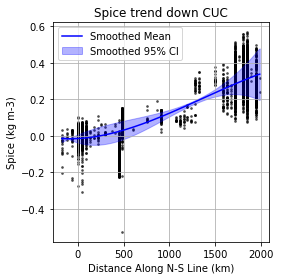

In [6]:
ylim = [30,55]
xlim = [-145,-115]

fig, ax = plt.subplots(1,1, figsize=(4, 4))


# — PARAMETERS —
pivot_lat = 48.5             # switch-over latitude
offset_m = 50e3             # 100 km offshore
tick_km = 2000               # label every 2000 km
leg_samps = 80              # how many points along each leg

# geodesic helper
geod = Geod(ellps='WGS84')

# grab the 2 000 m isobath as a Shapely geometry
iso2k_feature = NaturalEarthFeature(
    category='physical',
    name='bathymetry_I_2000',
    scale='10m',
)
iso2k = unary_union(list(iso2k_feature.geometries()))
iso2k = iso2k.simplify(tolerance=0.8, preserve_topology=True)

# — 1) build the NS (coast-following) leg: from 52°N to 30°N —
lats_NS = np.linspace(57, 30, leg_samps)
lons_NS_coast = np.array([isobath_lon(lat) for lat in lats_NS])

# offset each point 50 km offshore (az=270°)
azs_NS = np.full_like(lons_NS_coast, 270.0)
lons_NS, lats_NS, _ = geod.fwd(lons_NS_coast, lats_NS, azs_NS, np.full(leg_samps, offset_m))

# compute cumulative distances along NS leg (pivot at 48.5N)
_, _, segd_NS = geod.inv(lons_NS[:-1], lats_NS[:-1], lons_NS[1:], lats_NS[1:])
d_NS = np.concatenate([[0], np.cumsum(segd_NS)])

# set 48.5°N as 0 km reference
idx_pivot_NS = np.argmin(np.abs(lats_NS - pivot_lat))
d_NS = d_NS - d_NS[idx_pivot_NS]

# — 2) build the EW leg along pivot_lat (westward from pivot point) —
pivot_lon_coast = isobath_lon(pivot_lat)
pivot_lon_off, pivot_lat_off, _ = geod.fwd(pivot_lon_coast, pivot_lat, 270, offset_m)

lons_EW = np.linspace(pivot_lon_off, xlim[0], leg_samps)
lats_EW = np.full_like(lons_EW, pivot_lat_off)

# compute distances from pivot (negative westward)
_, _, segd_EW = geod.inv(lons_EW[:-1], lats_EW[:-1], lons_EW[1:], lats_EW[1:])
d_EW = -np.concatenate([[0], np.cumsum(segd_EW)])




d_NS_out, d_EW_out = along_track_distance_array(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'])

# For later
d_NS_out_all, d_EW_out_all = along_track_distance_array(obs['longitude (degrees_east)'], obs['latitude (degrees_north)'])
obs['NS_distance'] = d_NS_out_all

x = d_NS_out
y = obs_cuc['spice']
######


# Group by x
df = pd.DataFrame({'x': x, 'y': y})
grouped = df.groupby('x')

x_unique = grouped.mean().index.values
y_mean = grouped.mean()['y'].values
y_std = grouped.std()['y'].values
n = grouped.size().values

# Compute 95% CI
t_crit = stats.t.ppf(0.975, df=n-1)
ci = t_crit * y_std / np.sqrt(n)
lower = y_mean - ci
upper = y_mean + ci

# Interpolation points
x_fine = np.linspace(min(x_unique), max(x_unique), 400)

# Impute missing values
y_mean = interpolate_nan(x_unique, y_mean)
lower = interpolate_nan(x_unique, lower)
upper = interpolate_nan(x_unique, upper)


# 1. Use UnivariateSpline with moderate s
mean_spline = UnivariateSpline(x_unique, y_mean, s=10)
lower_spline = UnivariateSpline(x_unique, lower, s=10)
upper_spline = UnivariateSpline(x_unique, upper, s=10)

# 2. Evaluate and apply gaussian smoothing
y_mean_smooth = gaussian_filter1d(mean_spline(x_fine), sigma=2)
y_lower_smooth = gaussian_filter1d(lower_spline(x_fine), sigma=2)
y_upper_smooth = gaussian_filter1d(upper_spline(x_fine), sigma=2)


#######

# Plot
ax.scatter(d_NS_out, obs_cuc['spice'], s=3, alpha=0.55, c='k')

plt.plot(x_fine, y_mean_smooth, label='Smoothed Mean', color='blue')
plt.fill_between(x_fine, y_lower_smooth, y_upper_smooth,
                 color='blue', alpha=0.3, label='Smoothed 95% CI')
ax.set_xlim([min(d_NS_out)-100, max(d_NS_out)+100])
ax.set_xlabel('Distance Along N-S Line (km)')
ax.set_ylabel('Spice (kg m-3)')
ax.set_title('Spice trend down CUC')
ax.grid()
ax.legend()
plt.tight_layout()

In [7]:

def plot_property_NStrend(d_NS_out, var_string, current_string, subplot_pos):
    """
    Plot Property Trends up and down the north-south line with origin at bifurcation of California Current
    
    Parameters
    ----------
    d_NS_out : array
        distances along NS line
    var_string : string
        string like 'temperature (degC)' to select property
    current_string : string
        string for one of three currents - either 'CC', 'CUC, 'Shelf'
    subplot_pos : int or tuple
        subplot position
    
    Returns
    -------
    None
        just plots figure
    """

    if current_string=='CUC':
        obs_used = obs_cuc
    elif current_string=='Shelf':
        obs_used = obs_shelf
    elif current_string=='CC':
        obs_used = obs_cc
    else:
        raise Exception("Invalid Current Name") 

    ylim_dict = {'spice':[-2,2], 'temperature (degC)': [5,20], 'salinity (g kg-1)':[30,35]}

    
    x = d_NS_out
    y = obs_used[var_string]
    
    # Group by x
    df = pd.DataFrame({'x': x, 'y': y})
    df['x_bin'] = df['x'].apply(lambda x: custom_round(x, base=225))

    grouped = df.groupby('x_bin')

    x_unique = grouped.mean().index.values
    y_mean = grouped.mean()['y'].values
    y_std = grouped.std()['y'].values
    n = grouped.size().values
    
    # Compute 95% CI
    t_crit = stats.t.ppf(0.975, df=n-1)
    ci = t_crit * y_std / np.sqrt(n)

    lower = y_mean - ci
    upper = y_mean + ci
    
    if (current_string=='Shelf') & (var_string=='DO (umol kg-1)'):
        print(lower, upper)
    # Interpolation points
    x_fine = np.linspace(min(x_unique), max(x_unique), 400)
    
    # Impute missing values
    y_mean = interpolate_nan(x_unique, y_mean)
    lower = interpolate_nan(x_unique, lower)
    upper = interpolate_nan(x_unique, upper)

    if (current_string=='Shelf') & (var_string=='DO (umol kg-1)'):
        print(min(lower), max(upper))
    
    # Use UnivariateSpline with moderate s (more smooth, less wiggly)
    mean_spline = UnivariateSpline(x_unique, y_mean, s=4) #8
    lower_spline = UnivariateSpline(x_unique, lower, s=4)
    upper_spline = UnivariateSpline(x_unique, upper, s=4)

    if (current_string=='Shelf') & (var_string=='DO (umol kg-1)'):
        print(min(lower_spline(x_fine)), max(upper_spline(x_fine)))
    
    # Evaluate and apply gaussian smoothing
    y_mean_smooth = gaussian_filter1d(mean_spline(x_fine), sigma=2)
    y_lower_smooth = gaussian_filter1d(lower_spline(x_fine), sigma=2)
    y_upper_smooth = gaussian_filter1d(upper_spline(x_fine), sigma=2)

    
    # Plot
    ax[subplot_pos].scatter(x,y, s=3, alpha=0.55, c='k')
    ax[subplot_pos].plot(x_fine, y_mean_smooth, label='Smoothed Mean', color='blue')
    ax[subplot_pos].fill_between(x_fine, y_lower_smooth, y_upper_smooth,
                     color='blue', alpha=0.3, label='Smoothed 95% CI')

    if var_string in list(ylim_dict.keys()):
        ax[subplot_pos].set_ylim(ylim_dict[var_string])
    
    ax[subplot_pos].set_xlim([min(d_NS_out)-100, max(d_NS_out)+100])
    ax[subplot_pos].set_xlabel('Distance Along N-S Line (km)')
    if var_string == 'spice':
        ax[subplot_pos].set_ylabel('Spice (kg m-3)')
    else:
        ax[subplot_pos].set_ylabel(var_string)
    
    ax[subplot_pos].set_title(f'{var_string} trend down {current_string}')
    ax[subplot_pos].grid()
    ax[subplot_pos].legend()
    
    return None


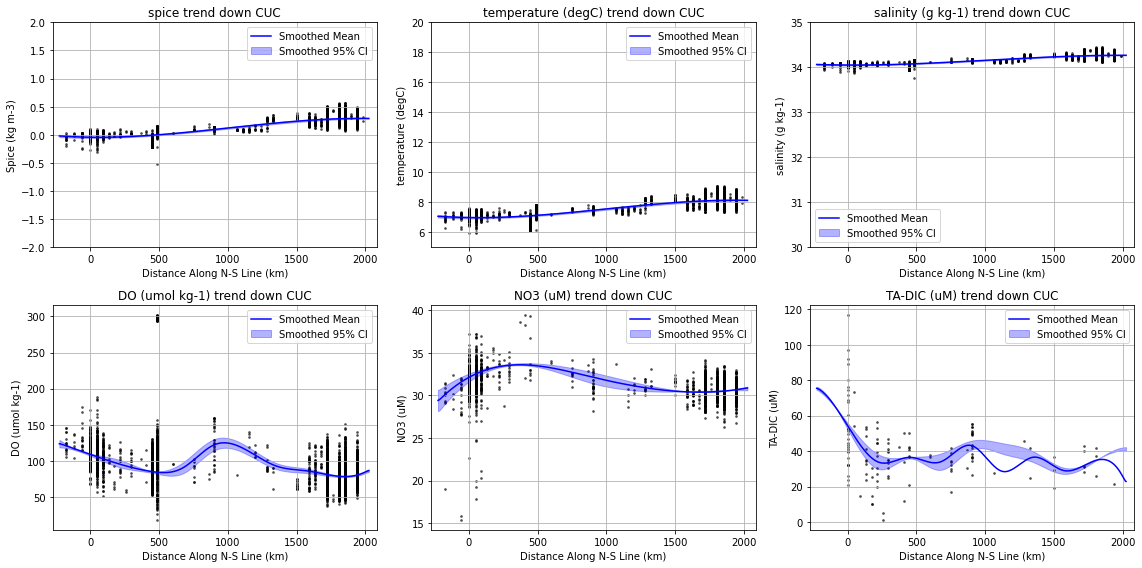

In [8]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))

ylim = [30,55]
xlim = [-145,-115]
# — PARAMETERS —
pivot_lat = 48.5             # switch-over latitude
offset_m = 50e3             # 100 km offshore
tick_km = 2000               # label every 2000 km
leg_samps = 80              # how many points along each leg

# geodesic helper
geod = Geod(ellps='WGS84')

# grab the 2 000 m isobath as a Shapely geometry
iso2k_feature = NaturalEarthFeature(
    category='physical',
    name='bathymetry_I_2000',
    scale='10m',
)
iso2k = unary_union(list(iso2k_feature.geometries()))
iso2k = iso2k.simplify(tolerance=0.8, preserve_topology=True)

# — 1) build the NS (coast-following) leg: from 52°N to 30°N —
lats_NS = np.linspace(57, 30, leg_samps)
lons_NS_coast = np.array([isobath_lon(lat) for lat in lats_NS])

# offset each point 50 km offshore (az=270°)
azs_NS = np.full_like(lons_NS_coast, 270.0)
lons_NS, lats_NS, _ = geod.fwd(lons_NS_coast, lats_NS, azs_NS, np.full(leg_samps, offset_m))

# compute cumulative distances along NS leg (pivot at 48.5N)
_, _, segd_NS = geod.inv(lons_NS[:-1], lats_NS[:-1], lons_NS[1:], lats_NS[1:])
d_NS = np.concatenate([[0], np.cumsum(segd_NS)])

# set 48.5°N as 0 km reference
idx_pivot_NS = np.argmin(np.abs(lats_NS - pivot_lat))
d_NS = d_NS - d_NS[idx_pivot_NS]

# — 2) build the EW leg along pivot_lat (westward from pivot point) —
pivot_lon_coast = isobath_lon(pivot_lat)
pivot_lon_off, pivot_lat_off, _ = geod.fwd(pivot_lon_coast, pivot_lat, 270, offset_m)

lons_EW = np.linspace(pivot_lon_off, xlim[0], leg_samps)
lats_EW = np.full_like(lons_EW, pivot_lat_off)

# compute distances from pivot (negative westward)
_, _, segd_EW = geod.inv(lons_EW[:-1], lats_EW[:-1], lons_EW[1:], lats_EW[1:])
d_EW = -np.concatenate([[0], np.cumsum(segd_EW)])

d_NS_out, d_EW_out = along_track_distance_array(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'])



plot_property_NStrend(d_NS_out, 'spice', 'CUC', (0,0))
plot_property_NStrend(d_NS_out, 'temperature (degC)', 'CUC', (0,1))
plot_property_NStrend(d_NS_out, 'salinity (g kg-1)', 'CUC', (0,2))
plot_property_NStrend(d_NS_out, 'DO (umol kg-1)', 'CUC', (1,0))
plot_property_NStrend(d_NS_out, 'NO3 (uM)', 'CUC', (1,1))
plot_property_NStrend(d_NS_out, 'TA-DIC (uM)', 'CUC', (1,2))

plt.tight_layout()

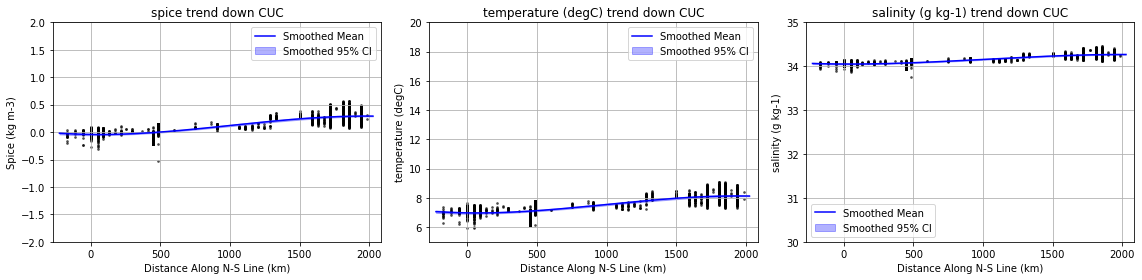

In [9]:
fig, ax = plt.subplots(1,3, figsize=(16, 4))

d_NS_out, d_EW_out = along_track_distance_array(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'])

plot_property_NStrend(d_NS_out, 'spice', 'CUC', 0)
plot_property_NStrend(d_NS_out, 'temperature (degC)', 'CUC', 1)
plot_property_NStrend(d_NS_out, 'salinity (g kg-1)', 'CUC', 2)

plt.tight_layout()

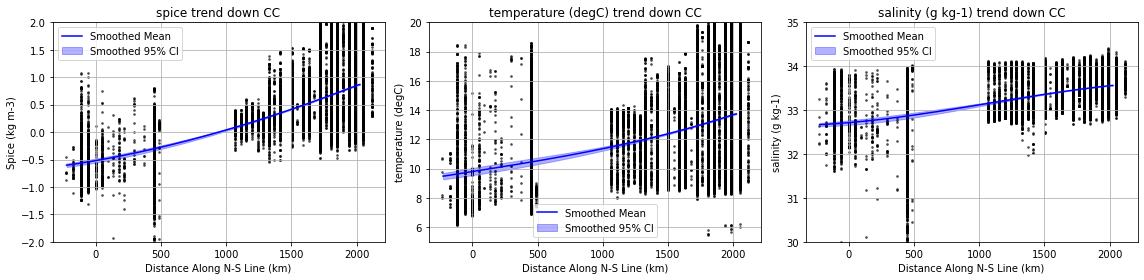

In [10]:
fig, ax = plt.subplots(1,3, figsize=(16, 4))

d_NS_out, d_EW_out = along_track_distance_array(obs_cc['longitude (degrees_east)'], obs_cc['latitude (degrees_north)'])

plot_property_NStrend(d_NS_out, 'spice', 'CC', 0)
plot_property_NStrend(d_NS_out, 'temperature (degC)', 'CC', 1)
plot_property_NStrend(d_NS_out, 'salinity (g kg-1)', 'CC', 2)

plt.tight_layout()

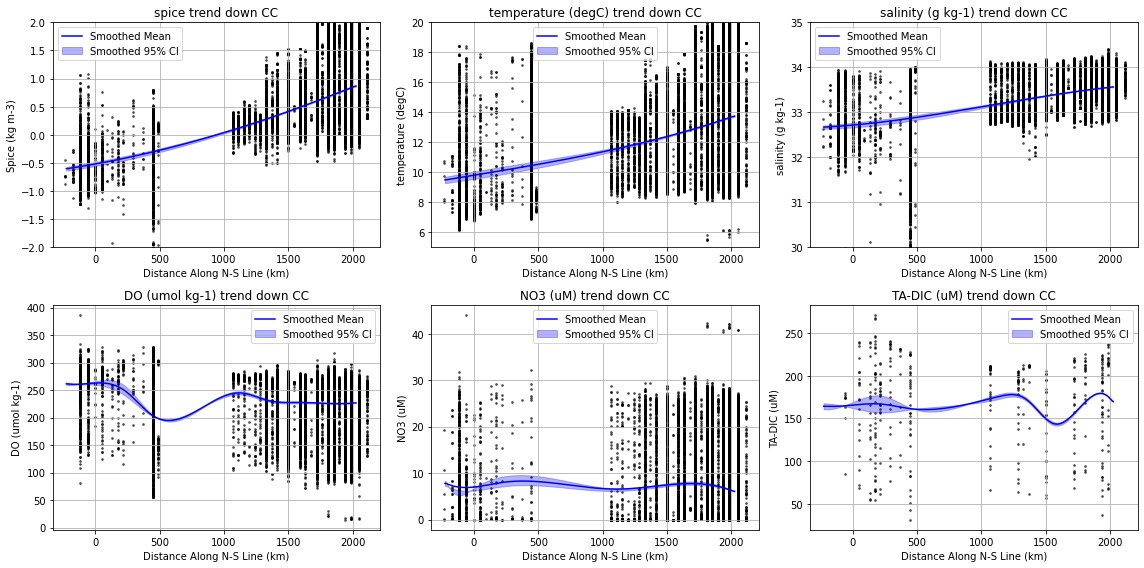

In [11]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))

d_NS_out, d_EW_out = along_track_distance_array(obs_cc['longitude (degrees_east)'], obs_cc['latitude (degrees_north)'])

plot_property_NStrend(d_NS_out, 'spice', 'CC', (0,0))
plot_property_NStrend(d_NS_out, 'temperature (degC)', 'CC', (0,1))
plot_property_NStrend(d_NS_out, 'salinity (g kg-1)', 'CC', (0,2))
plot_property_NStrend(d_NS_out, 'DO (umol kg-1)', 'CC', (1,0))
plot_property_NStrend(d_NS_out, 'NO3 (uM)', 'CC', (1,1))
plot_property_NStrend(d_NS_out, 'TA-DIC (uM)', 'CC', (1,2))

plt.tight_layout()

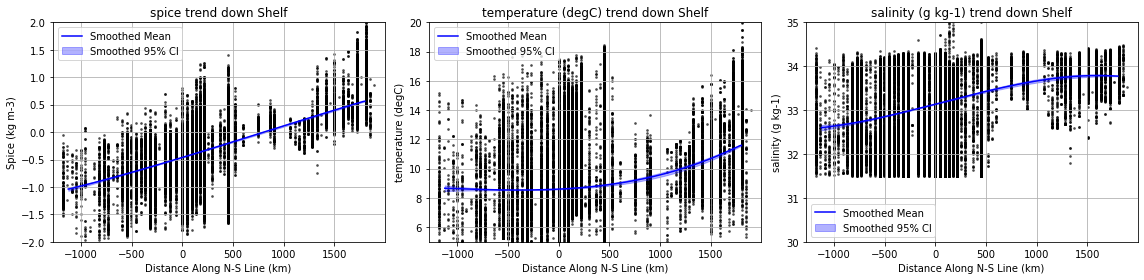

In [12]:
fig, ax = plt.subplots(1,3, figsize=(16, 4))

d_NS_out, d_EW_out = along_track_distance_array(obs_shelf['longitude (degrees_east)'], obs_shelf['latitude (degrees_north)'])

plot_property_NStrend(d_NS_out, 'spice', 'Shelf', 0)
plot_property_NStrend(d_NS_out, 'temperature (degC)', 'Shelf', 1)
plot_property_NStrend(d_NS_out, 'salinity (g kg-1)', 'Shelf', 2)

plt.tight_layout()

[211.88736822 192.80821647 190.15132718 176.39341619 150.11092039
 175.73856613 175.34350895 163.34099175 161.34322579 172.11813688
 190.33372622 189.69135729 169.08562369 191.96952883] [220.09666306 199.79732735 194.60893653 177.65409715 151.33372524
 176.69569782 177.2417026  163.9175628  178.39165754 185.66381716
 210.14226783 196.88899636 176.48152875 195.02089704]
150.1109203857321 220.09666305987258
151.33717070365597 220.10410224980316


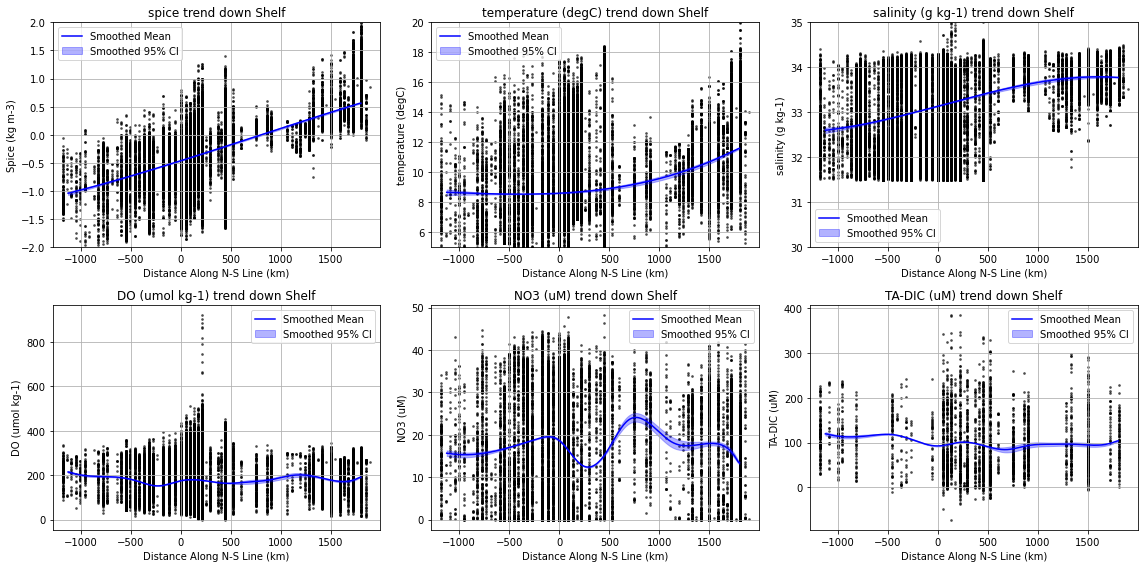

In [13]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))

d_NS_out, d_EW_out = along_track_distance_array(obs_shelf['longitude (degrees_east)'], obs_shelf['latitude (degrees_north)'])

plot_property_NStrend(d_NS_out, 'spice', 'Shelf', (0,0))
plot_property_NStrend(d_NS_out, 'temperature (degC)', 'Shelf', (0,1))
plot_property_NStrend(d_NS_out, 'salinity (g kg-1)', 'Shelf', (0,2))
plot_property_NStrend(d_NS_out, 'DO (umol kg-1)', 'Shelf', (1,0))
plot_property_NStrend(d_NS_out, 'NO3 (uM)', 'Shelf', (1,1))
plot_property_NStrend(d_NS_out, 'TA-DIC (uM)', 'Shelf', (1,2))

plt.tight_layout()

## Box and Whisker Plots

In [14]:
obs_northCCS = obs[obs['NS_distance'] <= 1000]
obs_centerCCS = obs[(obs['NS_distance'] <= 1750) & (obs['NS_distance'] >= 1000)]
obs_southCCS = obs[obs['NS_distance'] >= 1750]

In [15]:
def plot_property_boxwhisker(obs, var_string, current_string, subplot_pos):
    """
    Plot Property Trends up and down the north-south line with origin at bifurcation of California Current
    
    Parameters
    ----------
    obs : dataframe
        all data points
    var_string : string
        string like 'temperature (degC)' to select property
    current_string : string
        string for one of three currents - either 'CC', 'CUC, 'Shelf'
    subplot_pos : int or tuple
        subplot position
    
    Returns
    -------
    None
        just plots figure
    """
    obs_northCCS_current = obs[(obs['NS_distance'] <= 1000) & (obs['current'] == current_string)]
    obs_centerCCS_current = obs[(obs['NS_distance'] <= 1750) & (obs['NS_distance'] >= 1000) & (obs['current'] == current_string)]
    obs_southCCS_current = obs[(obs['NS_distance'] >= 1750) & (obs['current'] == current_string)]

    data = [obs_northCCS_current[var_string].dropna(), obs_centerCCS_current[var_string].dropna(), obs_southCCS_current[var_string].dropna()]
    labels = ['Northern', 'Central', 'Southern']
    
    # Plot boxplot
    ax[subplot_pos].boxplot(data, 
                            patch_artist=True, 
                            flierprops=dict(markerfacecolor='k', marker='o', markersize=2, alpha=0.5), 
                            medianprops=dict(color='k', linewidth=2), 
                            boxprops=dict(facecolor='lightblue'))
    ax[subplot_pos].set_xticklabels(labels)
    
    # Plot mean points
    means = [d.mean() for d in data]
    ax[subplot_pos].scatter([1, 2, 3], means, color='red', marker='D', label='Regional Means', s=10, alpha=0.7, zorder=6)
    
    ax[subplot_pos].set_xlabel('CCS Regions')
    if var_string == 'spice':
        ax[subplot_pos].set_ylabel('Spice (kg m-3)')
    else:
        ax[subplot_pos].set_ylabel(var_string)
    
    ax[subplot_pos].set_title(f'{var_string} across the {current_string}')
    ax[subplot_pos].legend()
    return None

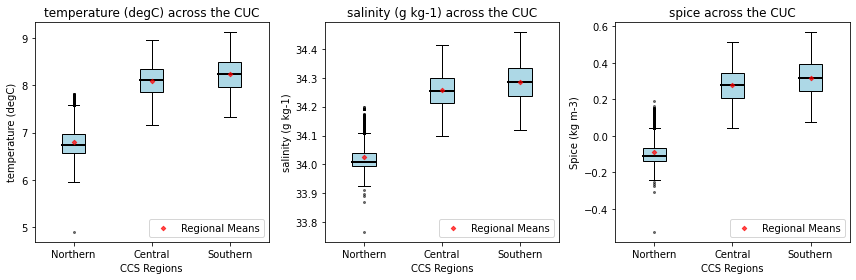

In [16]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
plot_property_boxwhisker(obs, 'temperature (degC)', 'CUC', 0)
plot_property_boxwhisker(obs, 'salinity (g kg-1)', 'CUC', 1)
plot_property_boxwhisker(obs, 'spice', 'CUC', 2)
plt.tight_layout()

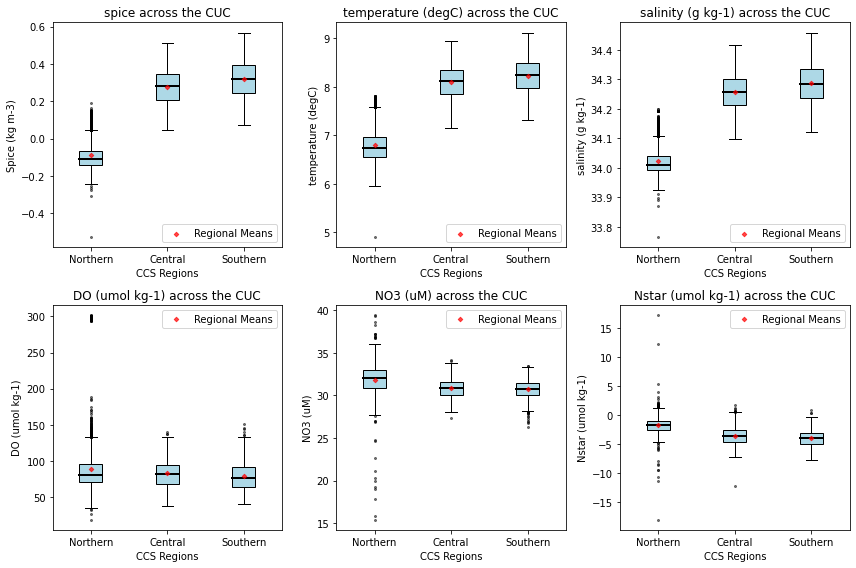

In [17]:
fig, ax = plt.subplots(2,3, figsize=(12, 8))
plot_property_boxwhisker(obs, 'spice', 'CUC', (0,0))
plot_property_boxwhisker(obs, 'temperature (degC)', 'CUC', (0,1))
plot_property_boxwhisker(obs, 'salinity (g kg-1)', 'CUC', (0,2))
plot_property_boxwhisker(obs, 'DO (umol kg-1)', 'CUC', (1,0))
plot_property_boxwhisker(obs, 'NO3 (uM)', 'CUC', (1,1))
plot_property_boxwhisker(obs, 'Nstar (umol kg-1)', 'CUC', (1,2))
plt.tight_layout()